### Importar librerías

In [1]:
# Importar librerías
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization,Activation
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import pydot
import graphviz

### Descargar el conjunto de datos

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### Exploración de los datos

In [3]:
print('Valor mínimo: ', x_train.min())
print('Valor máximo: ',x_train.max())

Valor mínimo:  0
Valor máximo:  255


In [4]:
# Determinar el tamaño del conjunto de entrenamiento (80% del total)
num_train = int(0.8 * x_train.shape[0])

# Dividir el conjunto de datos original de entrenamiento en un nuevo conjunto de entrenamiento y de validación
x_train, x_val = x_train[:num_train], x_train[num_train:]
y_train, y_val = y_train[:num_train], y_train[num_train:]

print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

x_train shape: (48000, 28, 28)
x_val shape: (12000, 28, 28)
y_train shape: (48000,)
y_val shape: (12000,)


In [5]:
# Redimensionamiento de los Conjuntos de Datos
x_train = x_train.reshape(-1, 28, 28, 1)  
x_test = x_test.reshape(-1, 28, 28, 1)   
x_val = x_val.reshape(-1, 28, 28, 1)

In [6]:
# Reescalar  imágenes
x_train = x_train / 255.0
x_test = x_test / 255.0
x_val = x_val/ 255.0

In [7]:
print('Valor mínimo: ', x_train.min())
print('Valor máximo: ', x_train.max())

Valor mínimo:  0.0
Valor máximo:  1.0


In [8]:
def visualize_dataset(n,x,y):
    plt.figure(figsize=(10,10))
    for i in range(n*n):
        plt.subplot(n,n,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x[i], cmap=plt.get_cmap('gray'))
        plt.xlabel(y[i])
    plt.show()

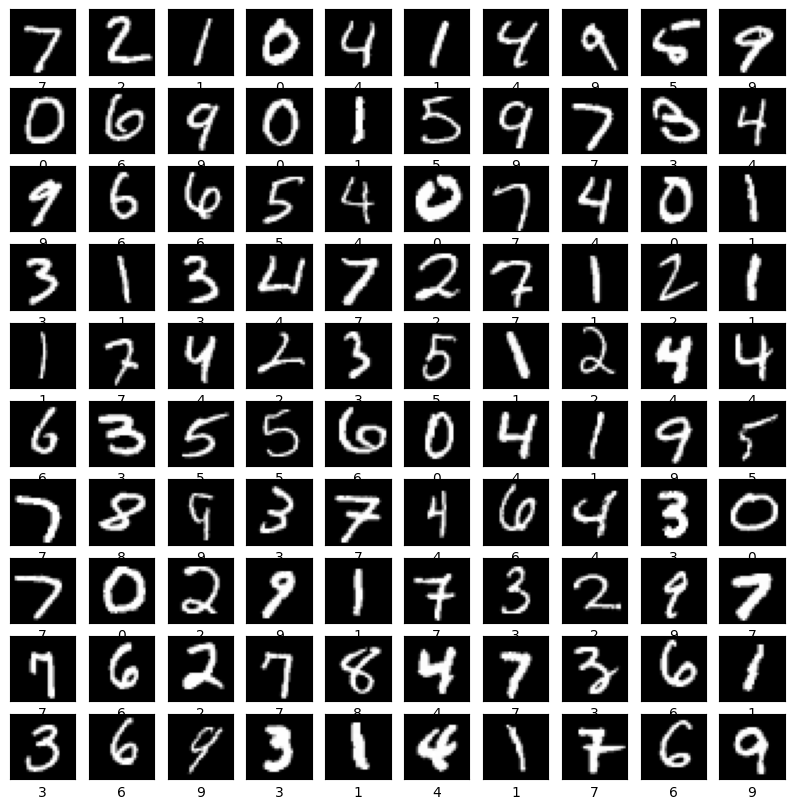

In [9]:
visualize_dataset(10, x_test, y_test)

Normalmente, cuando se hacen arquitecturas de red neuronal convolucional (CNN), el número de flitros del *kernel* se trabaja de menor a mayor, pero como no hay ninguna regla "escrita" en el que se debe de hacer esto,  para el modelo se experimentó con una arquitectura descendente. En otras palabras, se estableció el número de filtros del kernel de mayor a menor. 

### Definición del modelo
Se utiliza la estructura secuencial, donde cada capa tiene exactamente un tensor de entrada y un tensor de salida.

### Capa convolucional 1
1.  **Conv2D(128, (3, 3), input_shape=(28, 28, 1), padding="same", kernel_regularizer=l2(0.001)):**
    *   **Número de Filtros (Filtros):** 128
    *   **Tamaño del Kernel (K):** 3x3
    *   **Input Shape ($W_{in} \times H_{in}$):** 28x28
    *   **Padding (P):** "same" (mantiene el tamaño de la imagen igual si el stride es 1)
    *   **Stride (S):** Por defecto es 1 (no especificado)
    *   **Cálculo de Salida:** ($\mathbf{W_{out} = \frac{W_{in} - K + 2P}{S} + 1}$ )
        *   $\mathbf{W_{out} = \frac{28 - 3 + 2(1)}{1} + 1} = 28$ 
2.  **BatchNormalization, Activation('relu'), MaxPool2D(2, 2), Dropout(0.3):**
    *   Estas capas no cambian el tamaño de la imagen, pero MaxPool2D reduce las dimensiones a la mitad.
    *   **Salida de MaxPooling:** $\mathbf{\frac{Input - K}{S}+1}$
        *   $\mathbf{\frac{28 - 2}{2}+1} = 14$ 

### Capa convolucional 2
1.  **Conv2D(32, (3, 3), padding="same", kernel_regularizer=l2(0.001)):**
    *   **Número de Filtros (Filtros):** 32
    *   **Tamaño del Kernel (K):** 3x3
    *   **Input Shape ($W_{in} \times H_{in}$):** 14x14
    *   **Padding (P):** "same" (mantiene el tamaño de la imagen igual si el stride es 1)
    *   **Stride (S):** Por defecto es 1 (no especificado)
    *   **Cálculo de Salida ($\mathbf{W_{out} = \frac{W_{in} - K + 2P}{S} + 1}$ ):**
        *   $\mathbf{W_{out} = \frac{14 - 3 + 2(1)}{1} + 1} = 1$ 

2.  **BatchNormalization, Activation('relu'), MaxPool2D(2, 2), Dropout(0.25):**
    *   Estas capas no cambian el tamaño de la imagen, pero MaxPool2D reduce las dimensiones a la mitad.
    *   **Salida de MaxPooling:** $\mathbf{\frac{Input - K}{S}+1}$
        *   $\mathbf{\frac{14 - 2}{2}+1} = 7$ 

### Capa de aplanamiento
1.  **Flatten():**
    *   **Ancho de la capa anterior ($W_{p}$):** 7
    *   **Alto de la capa anterior ($H_{p}$):** 7
    *   **Número de filtros de la capa anterior ($F_{p}$):** 32
    *   **Formula:** $\mathbf{O_{maxP} = W_{p} • H_{p} • F_{p}}$
    *   **Calculo de salida:** 7 x 7 x 32 = 1,568

### Capas densas
1. **Dense(128, activation='relu')**
    *   **Num de entradas (A):** 1,568
    *   **Num de neuronas (B):** 128
        *   **Formula: $\mathbf{(A + 1) • B}$**
    *   **Parámetros entrenables:** 200,832  

2. **Dropout(0.5)**

3. **Dense(64, activation='relu')**
    *   **Neuronas capa anterior (A):** 128
    *   **Neuronas en la capa actual (B):** 64
    *   **Sesgo de capa actual (C):** 64
    *   **Formula: $\mathbf{A • B + C}$**
    *   **Parametros entrenables:** 8,256  

4. **Dropout(0.3)**

5. **Dense(10, activation='softmax')**
    *   **Neuronas capa anterior (A):** 64
    *   **Neuronas en la capa actual (B):** 10
    *   **Formula: $\mathbf{(A + 1) • B}$**
    *   **Parámetros entrenables:** 650



In [10]:
# Definición del primer modelo
model = Sequential()

# Capa convolucional 1
model.add(Conv2D(128, (3, 3), input_shape=(28, 28, 1), padding="same", kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.3)) 

# Capa convolucional 2
model.add(Conv2D(32, (3, 3), padding="same", kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.25))

# Aplanamiento y capas densas
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy']) #optimizer, loss, metric

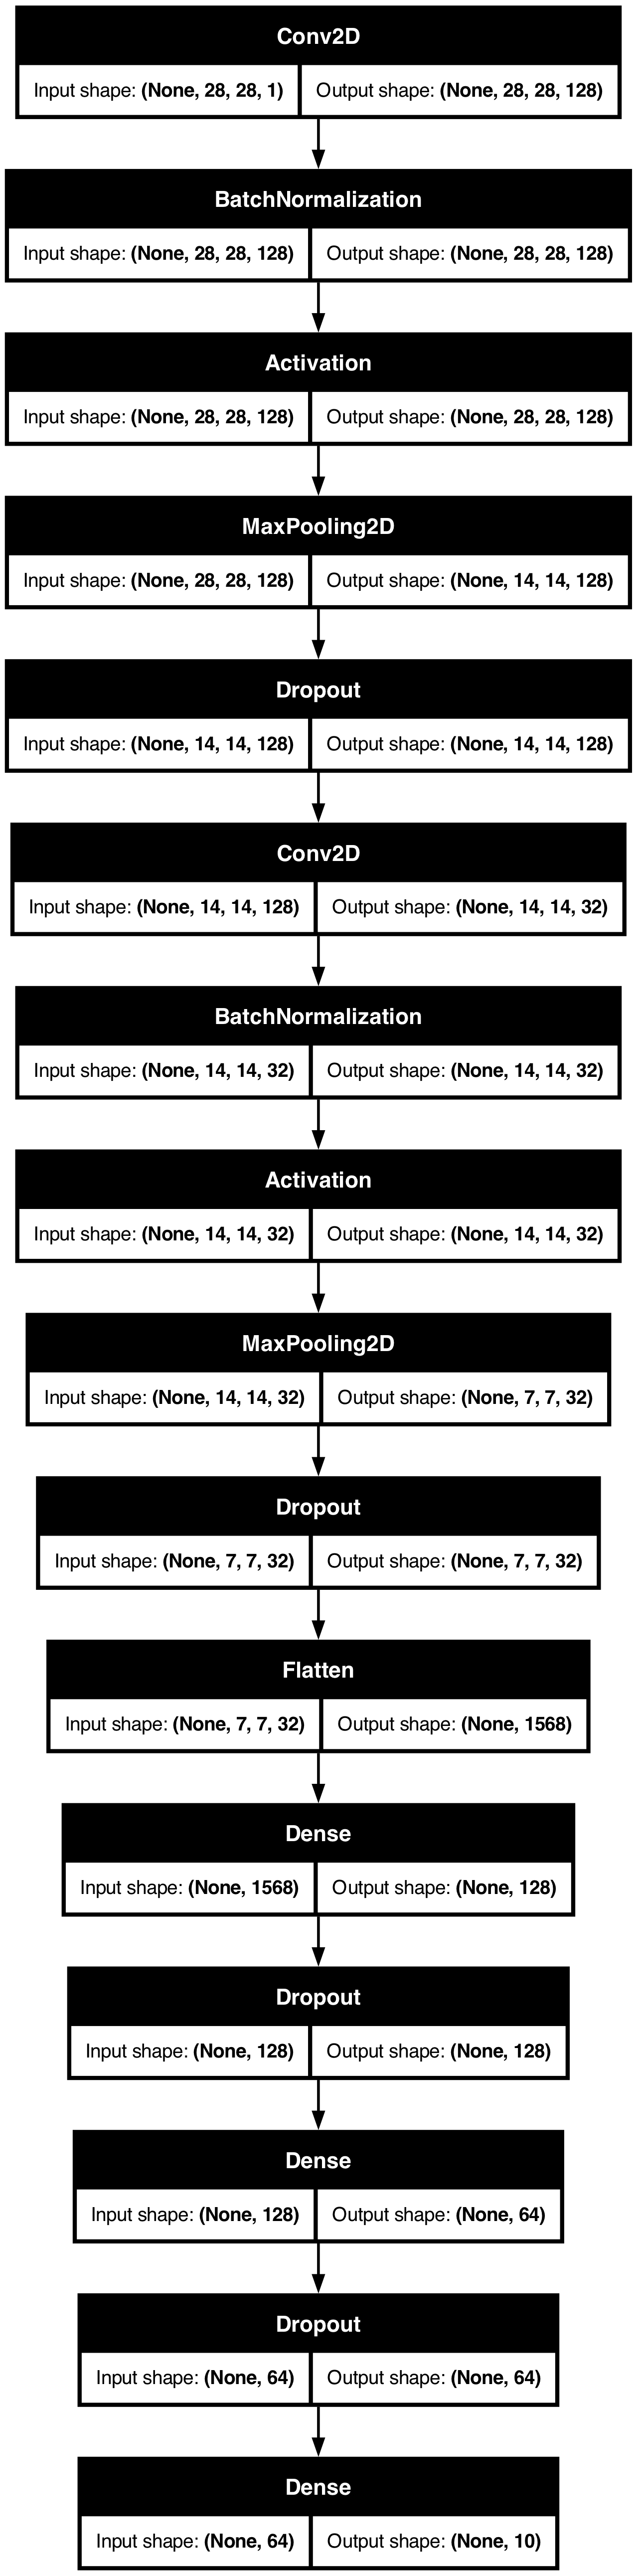

In [12]:
plot_model(model, show_shapes=True)

In [13]:
es = EarlyStopping(monitor='val_loss', patience=5,  mode='min',  verbose=1)
checkpoint = keras.callbacks.ModelCheckpoint("/Users/davidclemente/Documents/GitHub/MLwithtFW_2/model.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

### Entrenamiento del modelo

In [14]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),callbacks=[es, checkpoint] ,epochs=15,verbose=1)

Epoch 1/15
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6397 - loss: 1.1280
Epoch 1: val_loss improved from inf to 0.13300, saving model to /Users/davidclemente/Documents/GitHub/MLwithtFW_2/model.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.6399 - loss: 1.1273 - val_accuracy: 0.9745 - val_loss: 0.1330
Epoch 2/15
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9197 - loss: 0.3101
Epoch 2: val_loss improved from 0.13300 to 0.10227, saving model to /Users/davidclemente/Documents/GitHub/MLwithtFW_2/model.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.9197 - loss: 0.3101 - val_accuracy: 0.9831 - val_loss: 0.1023
Epoch 3/15
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9396 - loss: 0.2444
Epoch 3: val_loss did not improve from 0.10227
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.9396 - loss: 0.2444 - val_accuracy: 0.9825 - val_loss: 0.1040
Epoch 4/15
1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 

### Visualización del Rendimiento del Modelo

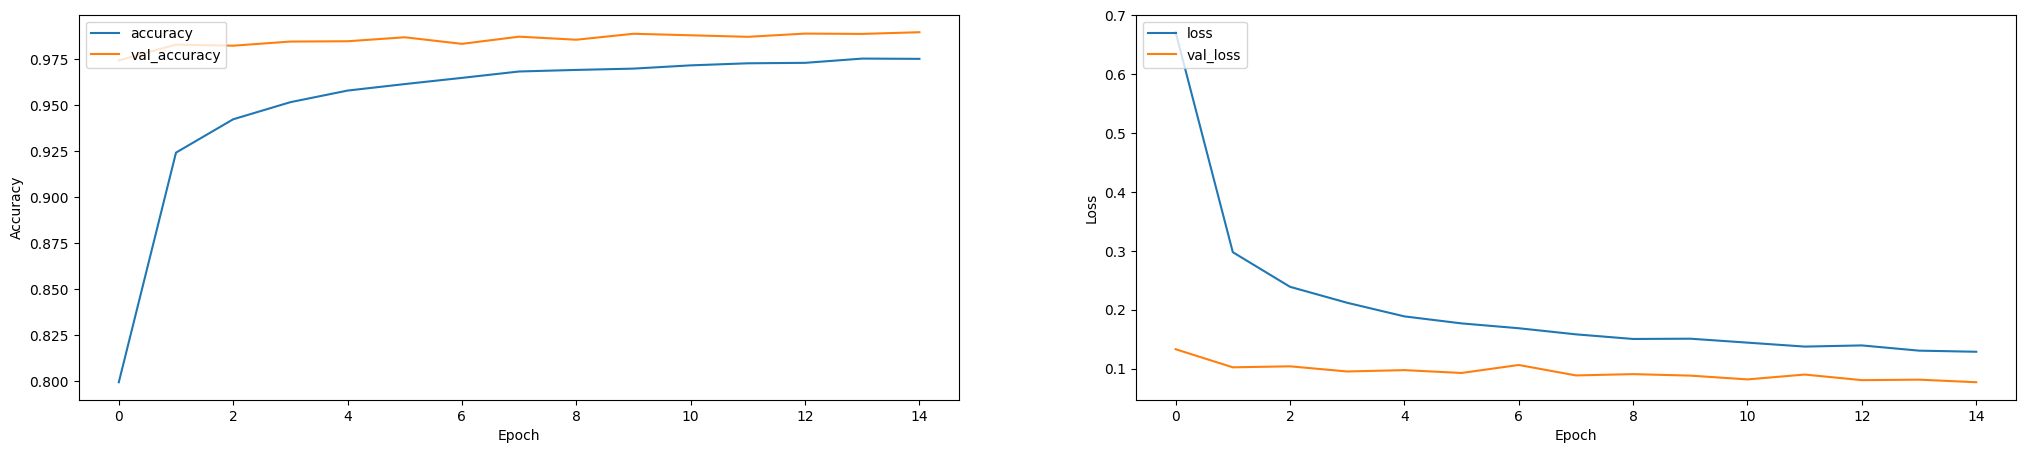

In [15]:
fig, axs = plt.subplots(1, 2,figsize=(25, 5))
axs[0].plot(history.history['accuracy'], label='accuracy')
axs[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='upper left')

axs[1].plot(history.history['loss'], label='loss')
axs[1].plot(history.history['val_loss'], label = 'val_loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper left')
plt.show()

In [17]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=0)
print(f'Test accuracy of Model: {test_acc:.2f}')
print(f'Test loss of Model: {test_loss:.2f}')

Test accuracy of Model: 0.99
Test loss of Model: 0.07


### Evalucación del modelo

In [18]:
y_pred = np.argmax(model.predict(x_test), axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



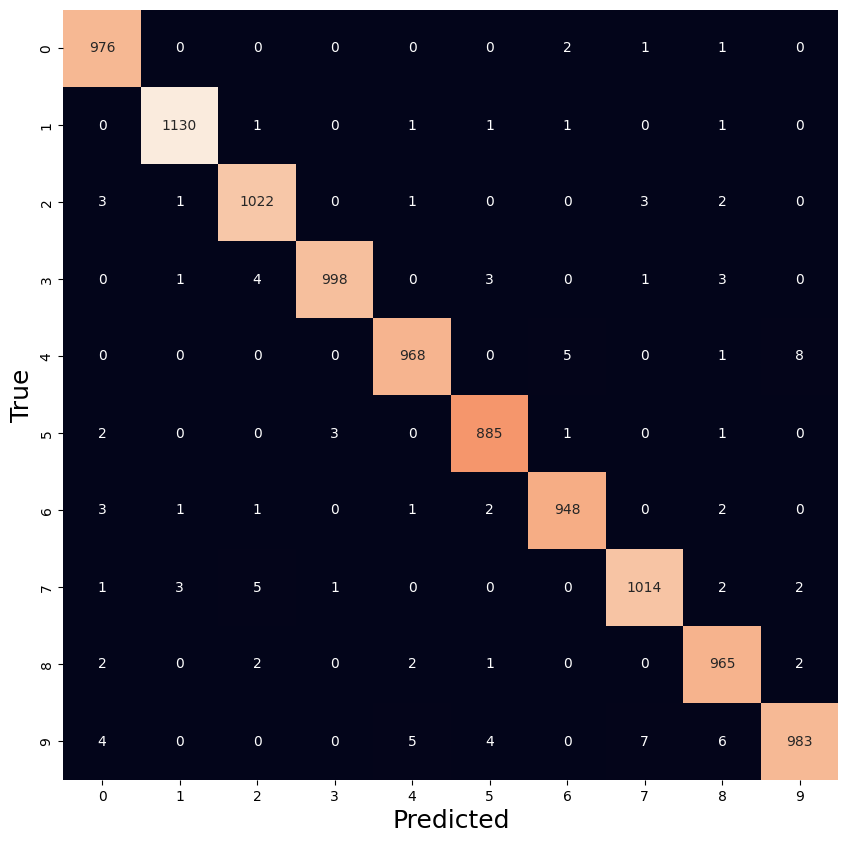

In [22]:
cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cf_matrix, annot=True,cbar=False,fmt='d')
plt.xlabel("Predicted", fontsize = 18)
plt.ylabel("True", fontsize = 18)
plt.show()

In [23]:
# Compara las clases predichas con las verdaderas
errors = y_pred != y_test

# Imágenes mal clasificadas
misclassified_images = x_test[errors]
misclassified_labels_true = y_test[errors]
misclassified_labels_pred = y_pred[errors]


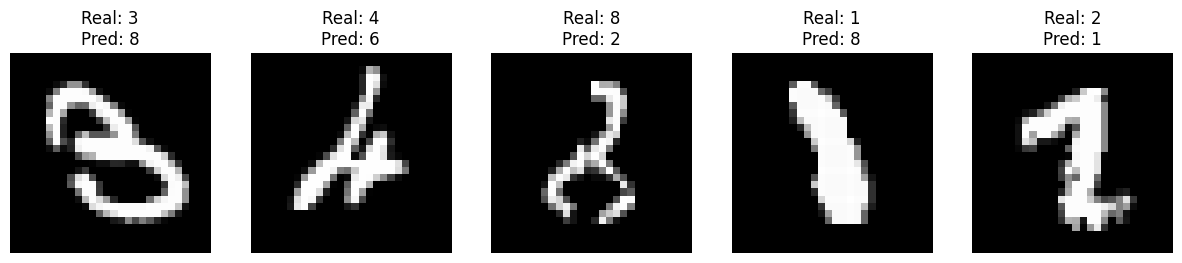

In [24]:
# Función para visualizar imágenes mal clasificadas
def plot_misclassified_images(images, true_labels, predicted_labels, n=5):
    plt.figure(figsize=(15, 4))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(np.squeeze(images[i]), cmap='gray')
        plt.title(f"Real: {true_labels[i]}\nPred: {predicted_labels[i]}")
        plt.axis('off')
    plt.show()

plot_misclassified_images(misclassified_images, misclassified_labels_true, misclassified_labels_pred, n=5)


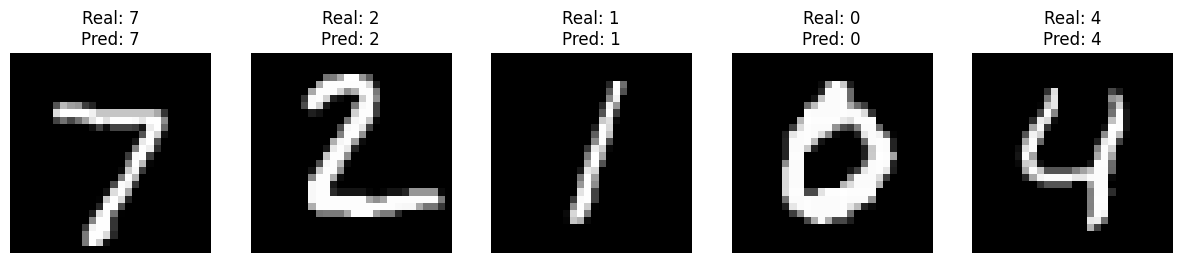

In [26]:
def plot_classification(images, true_labels, predicted_labels, n=5):
    correct = np.where(predicted_labels == true_labels)[0]

    plt.figure(figsize=(15, 4))
    for i, correct_idx in enumerate(correct[:n]):
        plt.subplot(1, n, i + 1)
        plt.imshow(np.squeeze(images[correct_idx]), cmap='gray')
        plt.title(f"Real: {true_labels[correct_idx]}\nPred: {predicted_labels[correct_idx]}")
        plt.axis('off')
    plt.show()

plot_classification(x_test, y_test, y_pred, n=5)